In [ ]:
import numpy as np
from plotnine import *
import pandas as pd

In [ ]:
results = pd.read_csv("benchmark_results.csv", sep='\t')

In [ ]:
nbse_info = pd.read_csv("nbse_sets.csv")

In [ ]:
data = results.merge(nbse_info, left_on=['name'], right_on=['set_name'])
data['mcs_size_to_atom_size'] = data['mcs_atoms'] / data['avg_atoms']
data = data.query('local_similarity > 0 and took < 900')
data.set_index(['name', 'optimizer_steps', 'optimizer_fine', 'optimizer_coarse',
                'num_conformers', 'core', 'assemblies'])

In [ ]:
data[data.name == ('1odn')]

In [ ]:
data.describe()

In [ ]:
metric_cols = ['siena_rmsd', 'avg_conformer_tanimoto_dist',
               'local_similarity', 'took']

program_parameters = ['assemblies', 'num_conformers', 'optimizer_coarse',
                      'optimizer_fine', 'optimizer_steps']

set_props = [str(c) for c in nbse_info.columns] + ['mcs_size_to_atom_size']

def lookup_en_name(s: str) -> str:
    name_lookup_en = {
        'name': 'Name',
        'took': 'Runtime',
        'siena_rmsd': 'SIENA RMSD',
        'avg_conformer_tanimoto_dist': 'Conformation Score',
        'local_similarity': 'Local Similarity',
        'most_atoms': 'Most Atoms',
        'least_atoms': 'Least Atoms',
        'most_bonds': 'Most Bonds',
        'least_bonds': 'Least Bonds',
        'num_mols': 'No. Molecules',
        'avg_atoms': 'Avg. Atoms',
        'mcs_atoms': 'Size MCS',
        'mcs_size_to_atom_size': 'Size MCS / Avg. Atoms',
        'optimizer_coarse': 'Optimizer Coarse',
        'optimizer_fine': 'Optimizer Fine',
        'optimizer_steps': 'Optimizer Steps',
        'num_conformers': 'No. Conformations',
        'assemblies': 'Assemblies'
    }

    if s in name_lookup_en:
        return name_lookup_en[s]
    else:
        return s

def lookup_de_name(s: str) -> str:
    return lookup_en_name(s)
    # name_lookup_de = {
    #     'name': 'Name',
    #     'took': 'Laufzeit',
    #     'siena_rmsd': 'SIENA RMSD',
    #     'avg_conformer_tanimoto_dist': 'Konformer Distanz',
    #     'local_similarity': 'Lokale Ähnlichkeit',
    #     'most_atoms': 'Meiste Atome',
    #     'least_atoms': 'Kleinste Atome',
    #     'most_bonds': 'Meiste Bindungen',
    #     'least_bonds': 'Wenigste Bindungen',
    #     'num_mols': 'Menge Moleküle',
    #     'avg_atoms': 'Durschn. Atome',
    #     'mcs_atoms': 'Größe MCS',
    #     'mcs_size_to_atom_size': 'MCS / Durchschn. Atome',
    #     'optimizer_coarse': 'Optimizer Coarse',
    #     'optimizer_fine': 'Optimizer Fine',
    #     'optimizer_steps': 'Optimizer Steps',
    #     'num_conformers': 'Konformere',
    #     'assemblies': 'Assemblies'
    # }
    # 
    # if s in name_lookup_de:
    #     return name_lookup_de[s]
    # else:
    #     return s


In [ ]:
metrics = data.drop(columns=['set_name', 'name', 'divide', 'core', 'mcs_bonds',
                             'avg_atoms_to_mcs'])
metrics.var()

In [ ]:
data.groupby(program_parameters).agg({ k: 'mean' for k in metrics})

In [ ]:
metrics.describe().transpose()

In [ ]:
correlation = 'pearson'
correlations = metrics.corr(method=correlation)
correlation = correlation.capitalize()

In [ ]:
corr = correlations.stack().reset_index()
corr.columns = ['var1', 'var2', 'val']
corr_config = corr.loc[corr['var2'].isin(metric_cols)]
corr_config = corr_config.loc[corr['var1'].isin(set_props)]
corr_config = corr_config.round({'val': 3})

corr_config['var1'] = corr_config['var1'].map(lookup_en_name)
corr_config['var2'] = corr_config['var2'].map(lookup_en_name)


In [ ]:
corr

In [ ]:
(ggplot(corr_config, mapping=aes('var2', 'var1', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Metrics', y='Dimensions', caption='Correlation: {}'.format(correlation))
 )

In [ ]:
corr_metrics = corr[
    corr['var1'].isin(metric_cols) & corr['var2'].isin(metric_cols)]
corr_metrics = corr_metrics.round({'val': 3})

corr_metrics['var1'] = corr_metrics['var1'].map(lookup_en_name)
corr_metrics['var2'] = corr_metrics['var2'].map(lookup_en_name)


In [ ]:
(ggplot(corr_metrics, mapping=aes('var1', 'var2', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Metrics', y='Metrics', caption='Correlation: {}'.format(correlation))
 )

In [ ]:
corr_options = corr[
    corr['var1'].isin(program_parameters) & corr['var2'].isin(metric_cols)]
corr_options = corr_options.round({'val': 3})
corr_options['var1'] = corr_options['var1'].map(lookup_de_name)
corr_options['var2'] = corr_options['var2'].map(lookup_de_name)


In [ ]:
(ggplot(corr_options, mapping=aes('var1', 'var2', fill='val', label='val'))
 + geom_tile()
 + scale_fill_gradient2(low='#79c9c9', high='#C97979', guide=False)
 + theme(axis_text_x=element_text(rotation=45, hjust=1))
 + geom_text()
 + labs(x='Parameters', y='Metrics',caption='Correlation: {}'.format(correlation))
 )


In [ ]:
(ggplot(data=data, mapping=aes(x='local_similarity', y='siena_rmsd'))
 + geom_point()
 + geom_smooth(method='lm')
 + labs(x=lookup_de_name('local_similarity'), y=lookup_de_name('siena_rmsd'))
 )

In [ ]:
(ggplot(data=data,
        mapping=aes(x='local_similarity', y='siena_rmsd', colour='name',
                    label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_en_name('local_similarity'), y=lookup_en_name('siena_rmsd'))
 )


In [ ]:
(ggplot(data=data, mapping=aes(x='mcs_size_to_atom_size', y='local_similarity'))
 + geom_point()
 + geom_smooth()
 + labs(x=lookup_de_name('mcs_size_to_atom_size'), y=lookup_de_name('local_similarity'))
 )

In [ ]:
(ggplot(data=data, mapping=aes(x='mcs_size_to_atom_size', y='local_similarity',
                               colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(), boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('mcs_size_to_atom_size'), y=lookup_de_name('local_similarity'))
 )


In [ ]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist'))
 + geom_point()
 + geom_smooth(method='lm')
 + labs(x=lookup_de_name('avg_atoms'), y=lookup_de_name('avg_conformer_tanimoto_dist'))
 )

In [ ]:
(ggplot(data=data, mapping=aes(x='siena_rmsd', y='avg_conformer_tanimoto_dist', colour='name', size='avg_atoms'))
 + geom_point()
 + labs(x=lookup_de_name('siena_rmsd'), y=lookup_de_name('avg_conformer_tanimoto_dist'), size=lookup_en_name('avg_atoms'))
 + scale_color_discrete(guide=False)
 )


In [ ]:
(ggplot(data=data, mapping=aes(x='siena_rmsd', y='avg_conformer_tanimoto_dist', colour='name', label='name'))
 + geom_point()
 + labs(x=lookup_de_name('siena_rmsd'), y=lookup_de_name('avg_conformer_tanimoto_dist'), size=lookup_en_name('avg_atoms'))
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


In [ ]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='avg_conformer_tanimoto_dist', colour='name', label='name'))
 + geom_point()
 + labs(x=lookup_de_name('avg_atoms'),
        y=lookup_de_name('avg_conformer_tanimoto_dist'))
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 )


In [ ]:
(ggplot(data=data, mapping=aes(x='avg_atoms', y='local_similarity',
                               colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('avg_atoms'), y=lookup_de_name('local_similarity'))
 )


In [ ]:
(ggplot(data=data, mapping=aes(x='num_mols', y='took', colour='core'))
 + geom_point()
 + geom_smooth(method='lm')
 + labs(x=lookup_de_name('num_mols'), y=lookup_de_name('took'), colour=lookup_en_name('core'))
 )

In [ ]:
(ggplot(data=data,
        mapping=aes(x='num_mols', y='took', colour='name', label='name'))
 + geom_point()
 + geom_label(data=data.groupby('name').first().reset_index(),
              boxcolor=(1, 1, 1, 0))
 + scale_color_discrete(guide=False)
 + labs(x=lookup_de_name('num_mols'), y=lookup_de_name('took'))
 )

In [81]:
(ggplot(data=data, mapping=aes(x='optimizer_coarse', y='took', colour='core'))
 + geom_point()
 + labs(x=lookup_de_name('num_mols'), y=lookup_de_name('took'), colour=lookup_en_name('core'))
 )


NameError: name 'ggplot' is not defined

In [8]:
from benchmark_nbse import get_nbse_mols
from rdkit.Chem.Draw import rdMolDraw2D
from rdkit.Chem import Draw
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import IPythonConsole
from rdkit.Chem import rdFMCS
from rdkit.Chem.Scaffolds.MurckoScaffold import  GetScaffoldForMol
from IPython.display import display
import os
import random

In [24]:
mols = list(map(AllChem.MolFromSmiles, [
    'CN1C2CCC1C(C(C2)OC(=O)C3=CC=CC=C3)C(=O)OC\tCocaine',
    'CCC(=O)N(C1CCN(CC1)CCC2=CC=CC=C2)C3=CC=CC=C3\tFentanyl' 
]))

murcko1 = GetScaffoldForMol(mols[0])
murcko2 = GetScaffoldForMol(mols[1])
murckos = [murcko1, murcko2]


mcs: rdFMCS.MCSResult = rdFMCS.FindMCS(mols,
                                       ringMatchesRingOnly=True,
                                       matchChiralTag=False,
                                       completeRingsOnly=True,
                                       atomCompare=rdFMCS.AtomCompare.CompareAnyHeavyAtom,
                                       bondCompare=rdFMCS.BondCompare.CompareOrder)


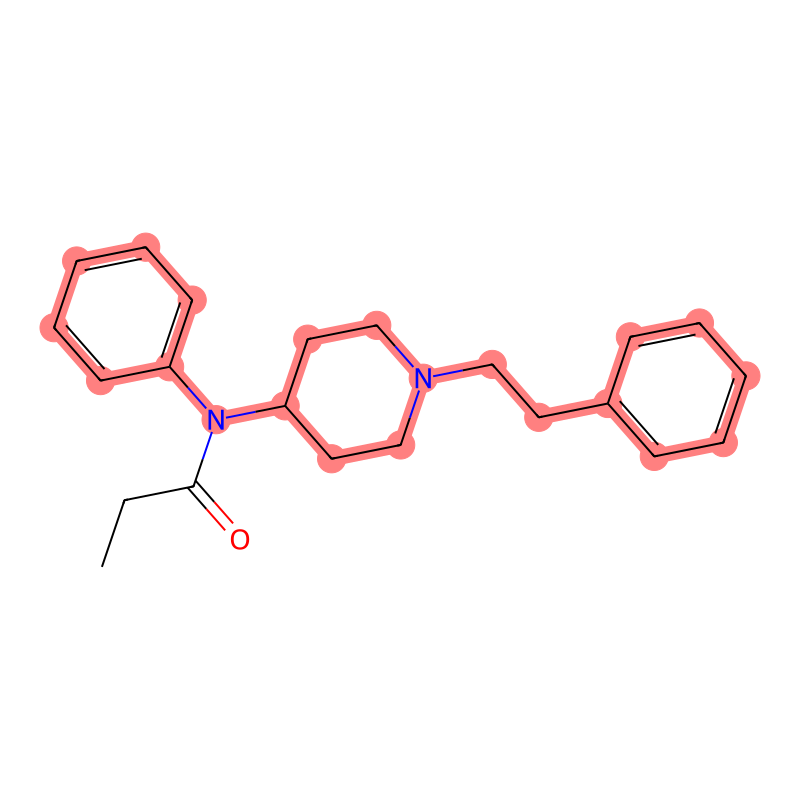

In [40]:
from rdkit.Chem.Draw import IPythonConsole

IPythonConsole.molSize = (800, 800)   # Change image size
mols[1].GetSubstructMatches(murcko2)
display(mols[1])

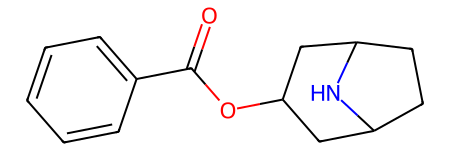

In [32]:
murcko1

In [23]:
hla = []
hlb = []
m: AllChem.Mol
for m in [mols[0]]:
    am = list(m.GetSubstructMatch(murcko1))
    hla.append(am)
    bm = []
    for bond in mcs.queryMol.GetBonds():
        aid1 = am[bond.GetBeginAtomIdx()]
        aid2 = am[bond.GetEndAtomIdx()]
        bm.append(m.GetBondBetweenAtoms(aid1,aid2).GetIdx())

    hlb.append(bm)

display(Draw.MolsToGridImage([mols[0]], molsPerRow=1,subImgSize=(700,700),legends=[x.GetProp("_Name") for x in mols], highlightBondLists=hlb, highlightAtomLists=hla))



AttributeError: 'NoneType' object has no attribute 'GetIdx'

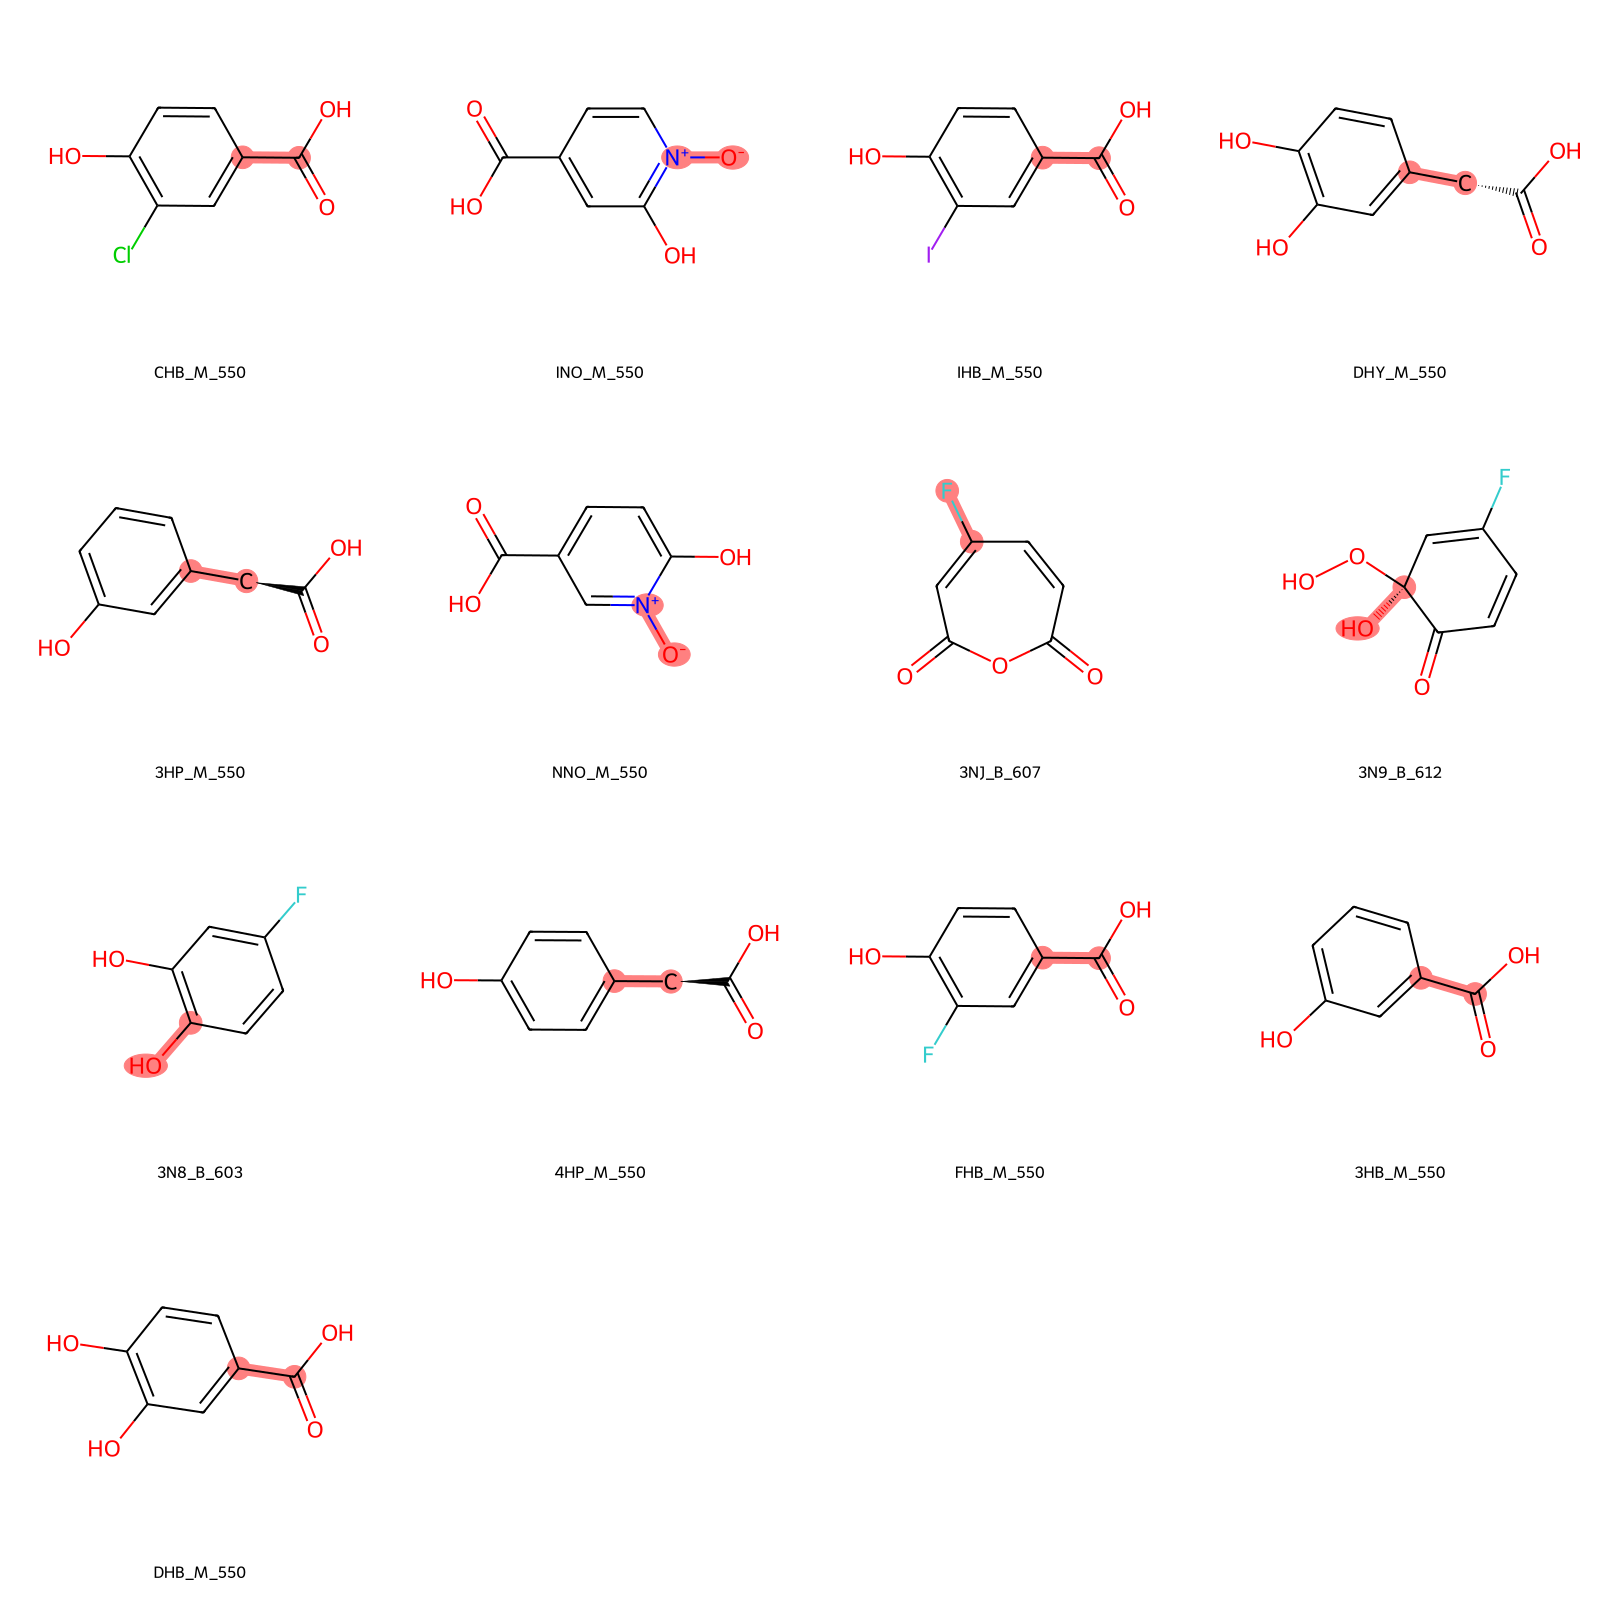

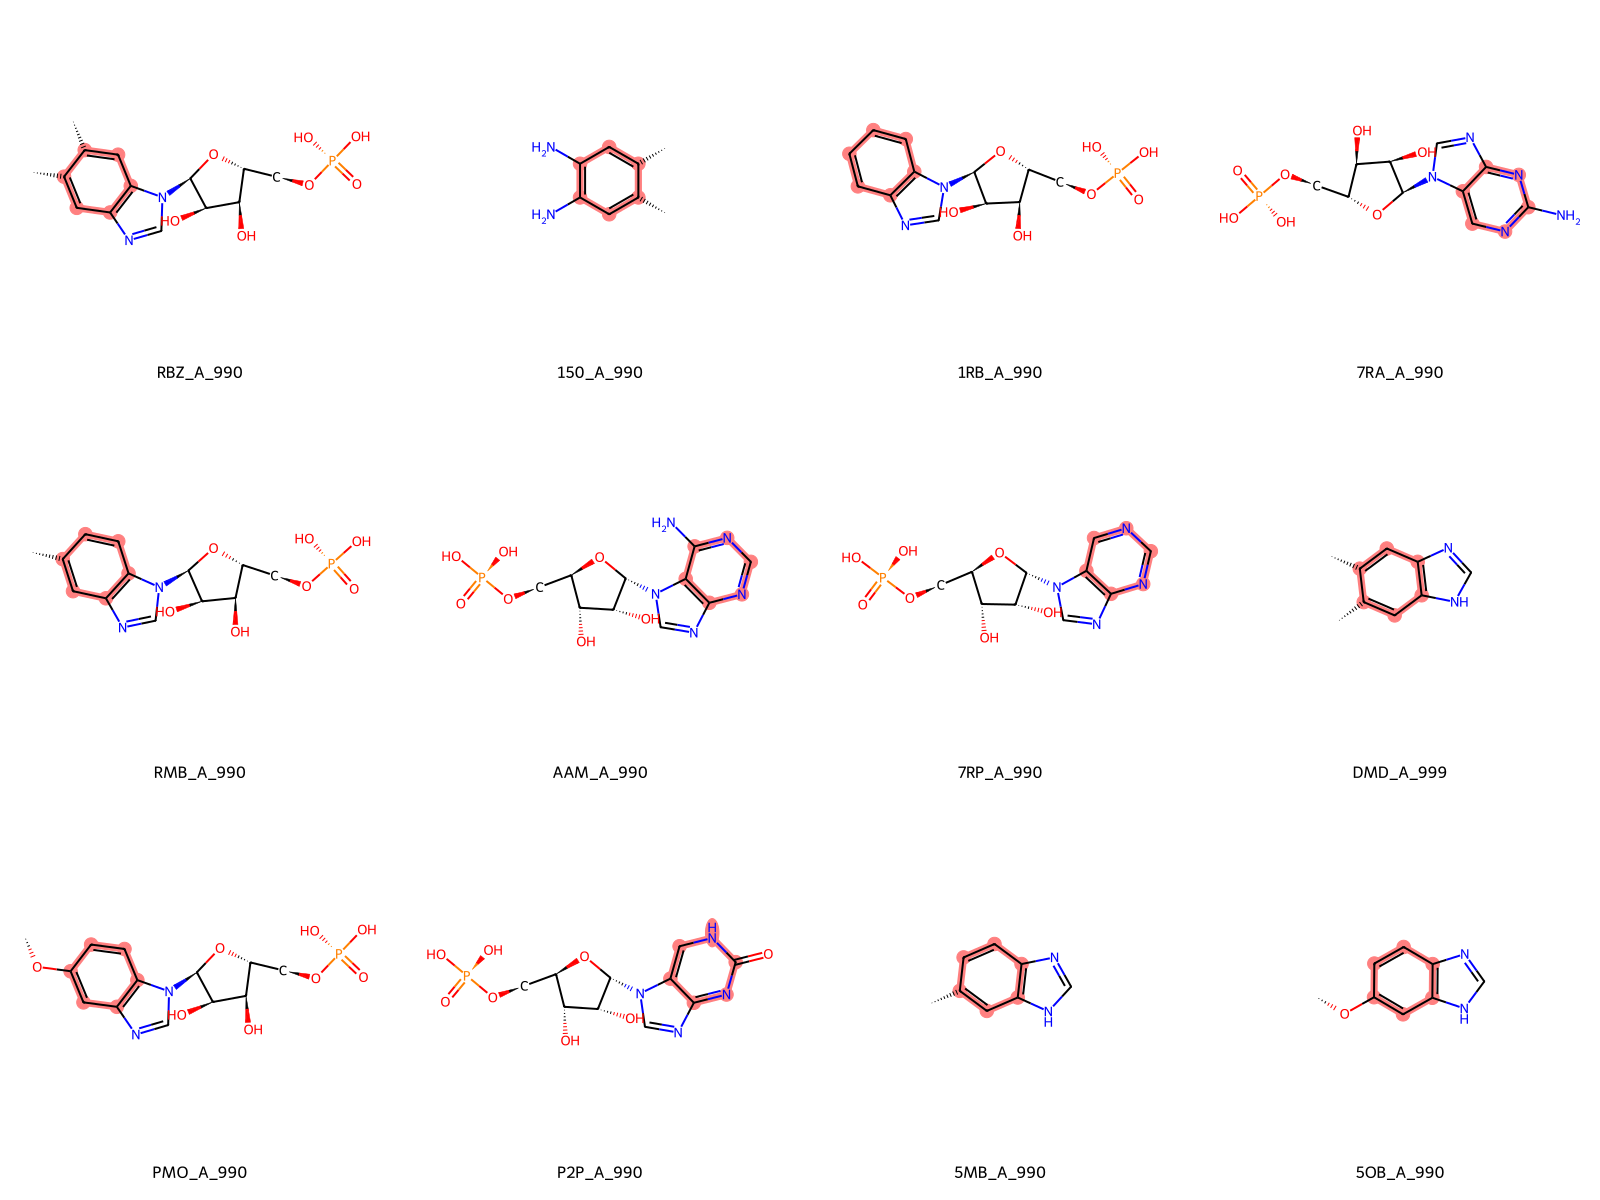

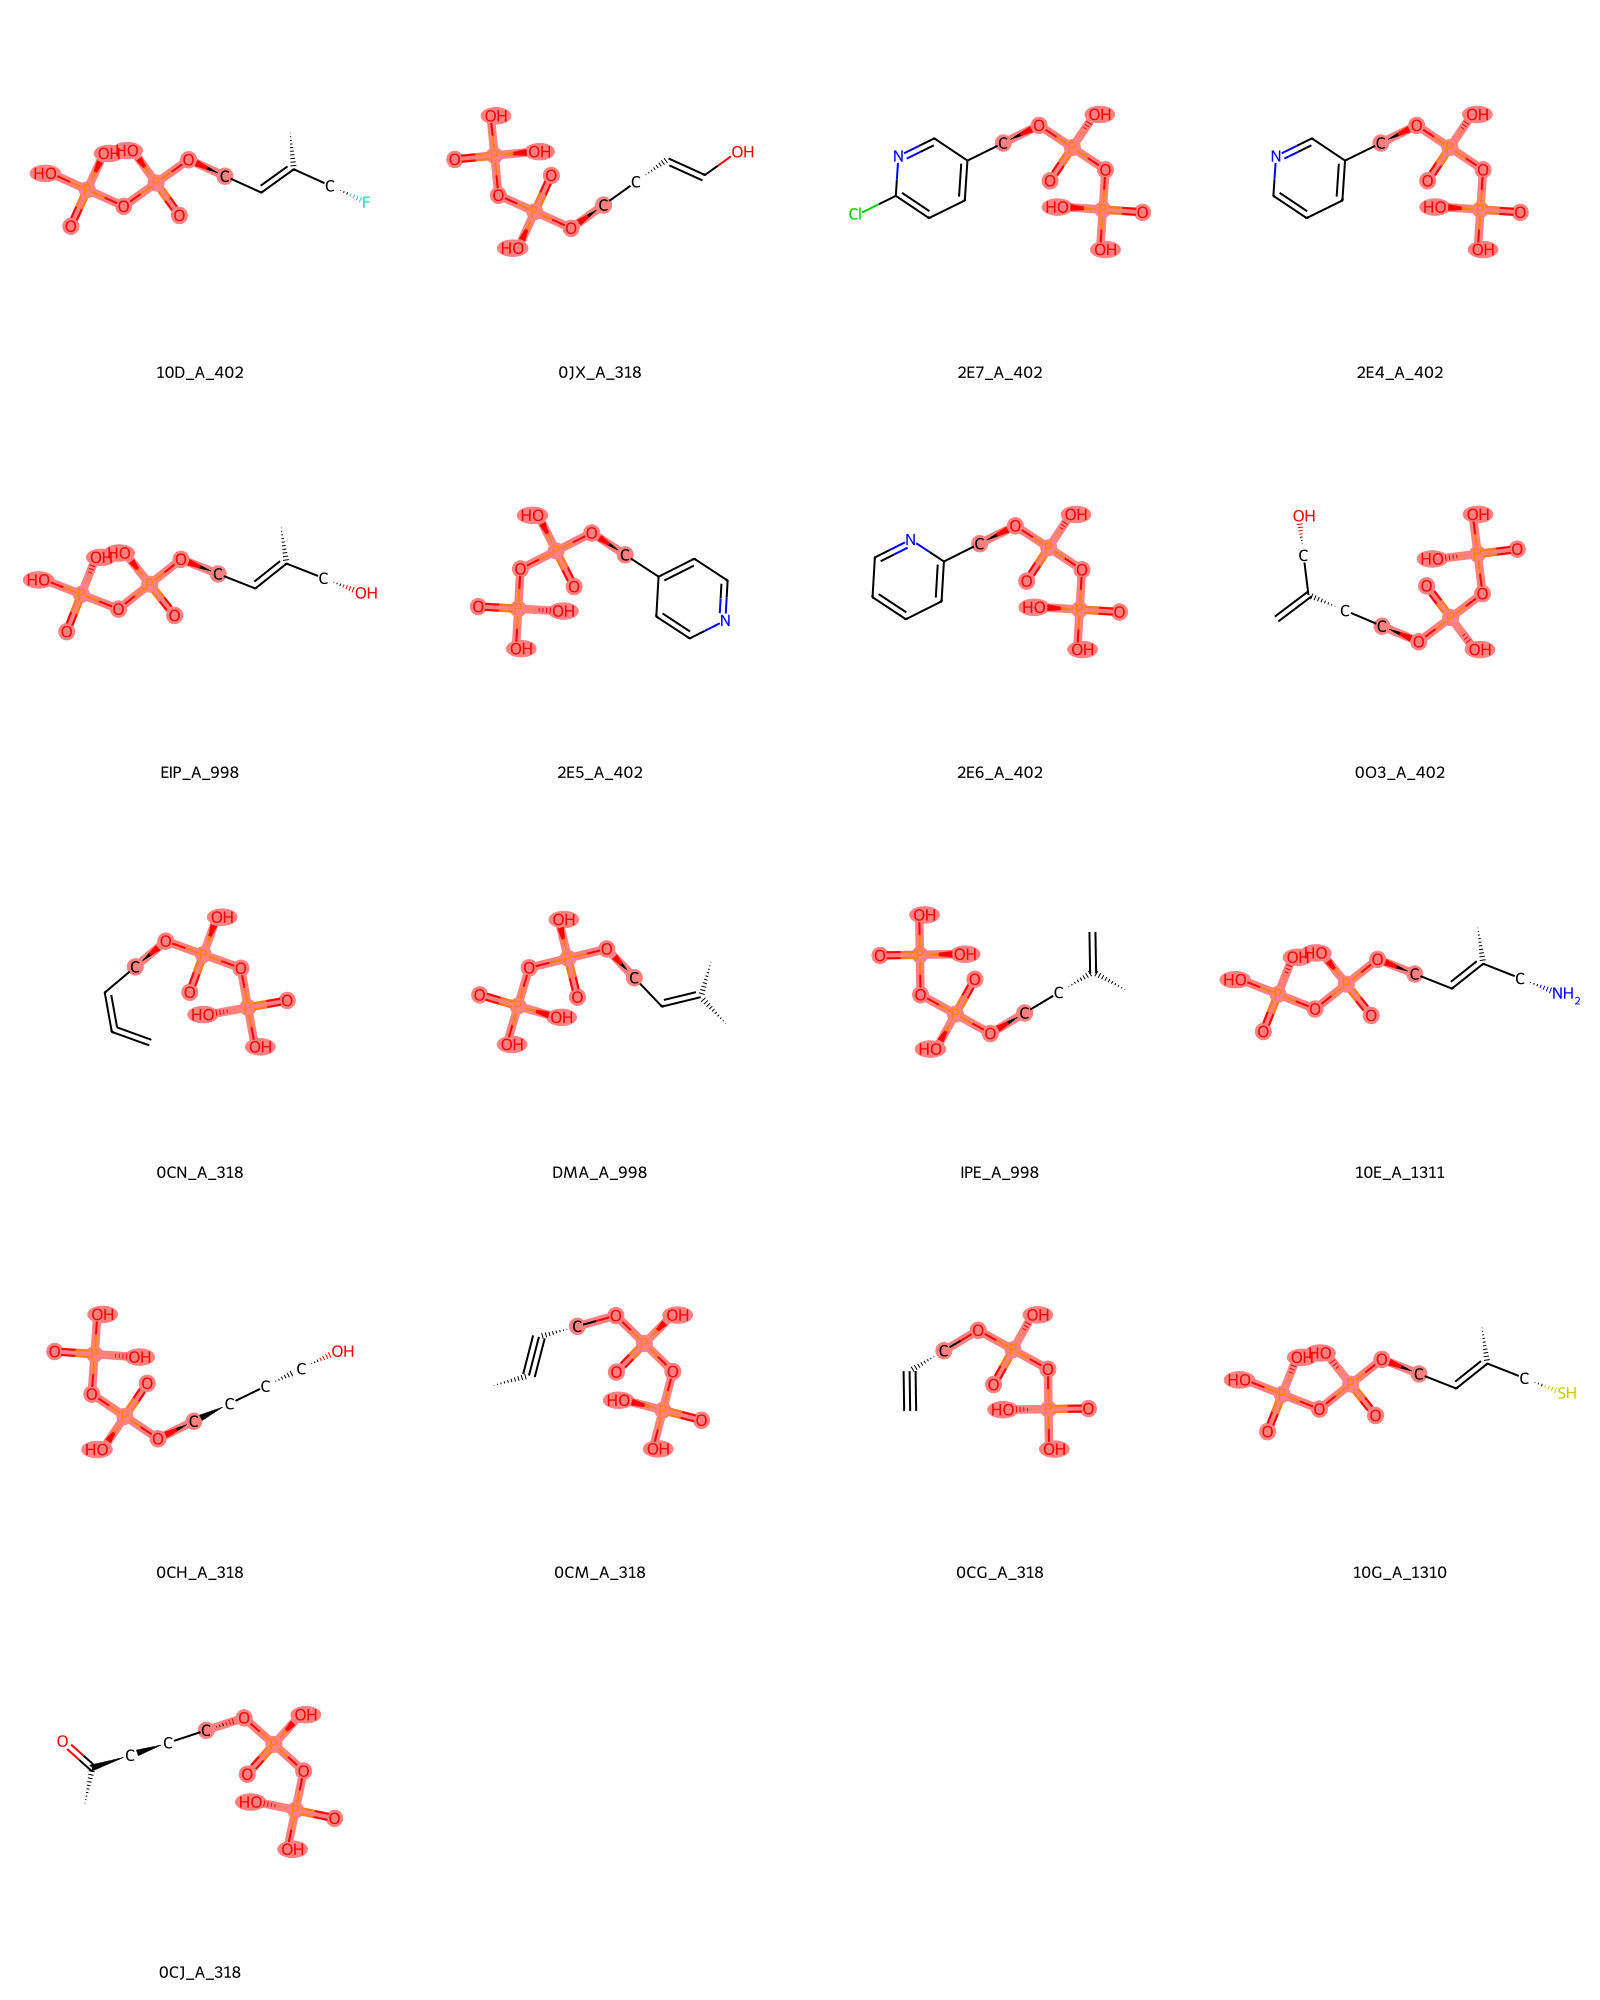

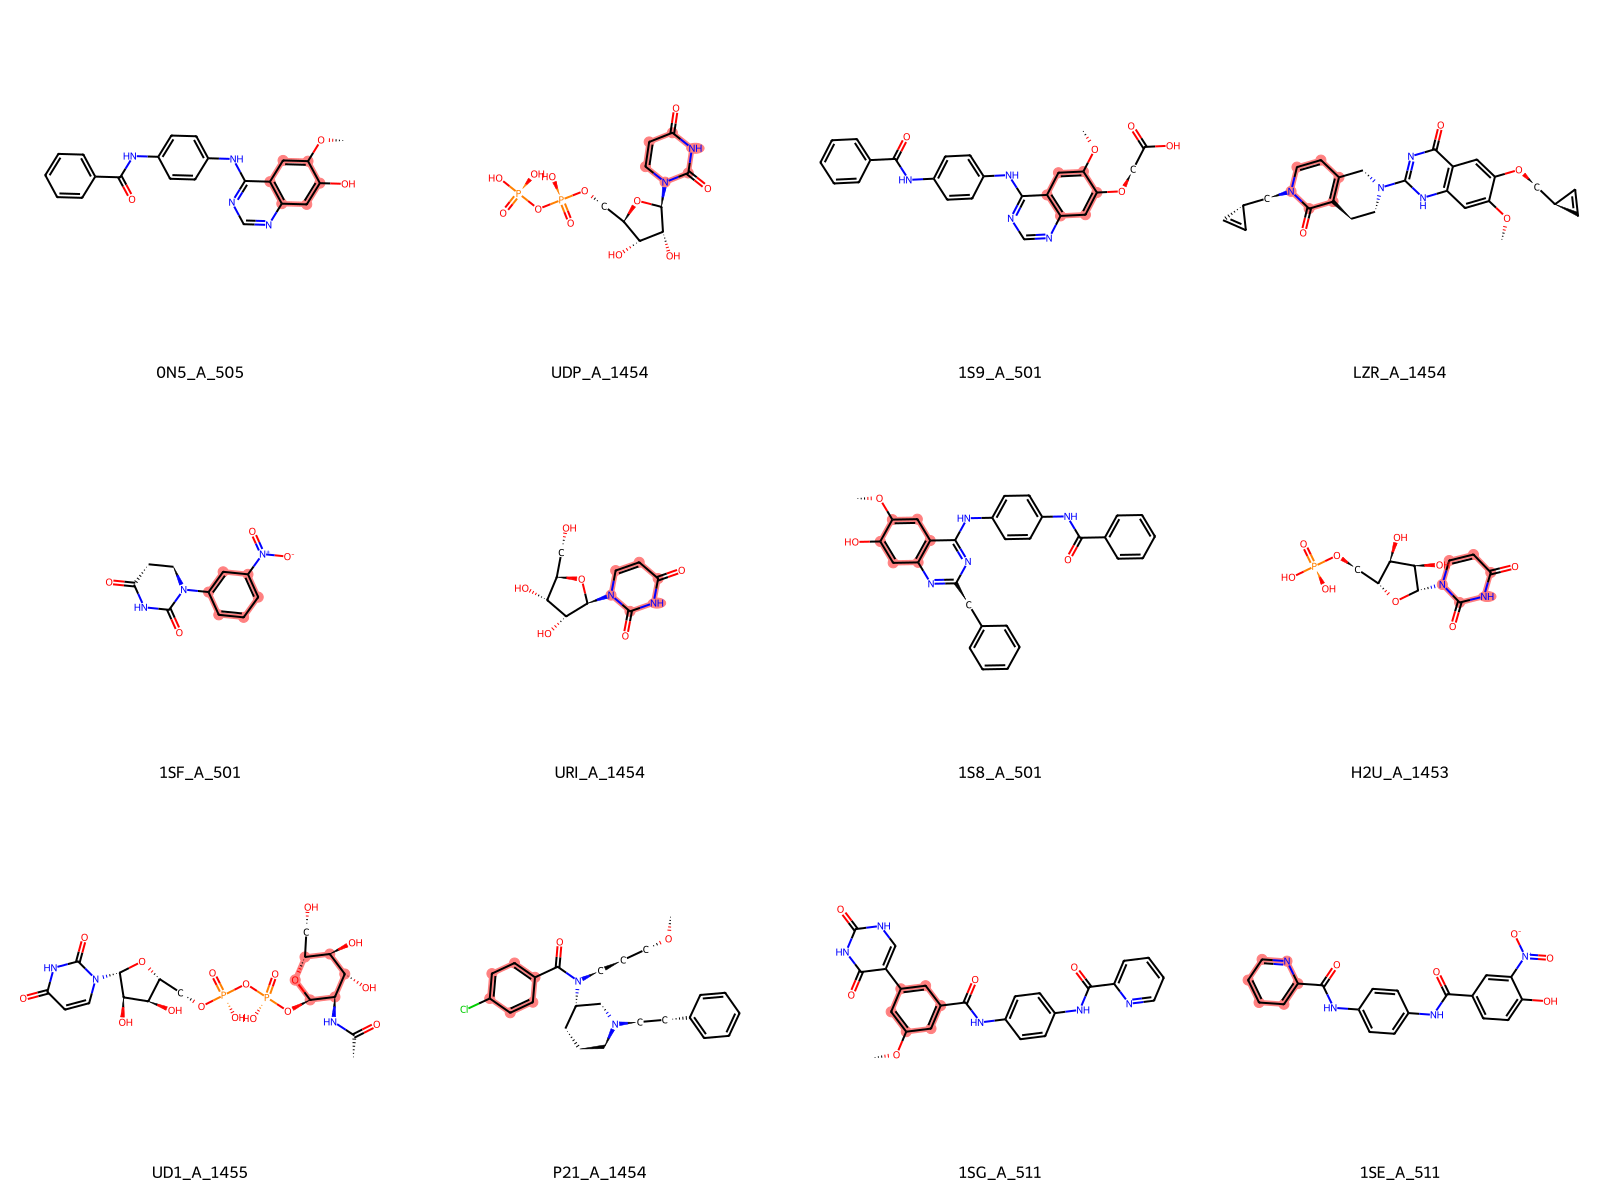

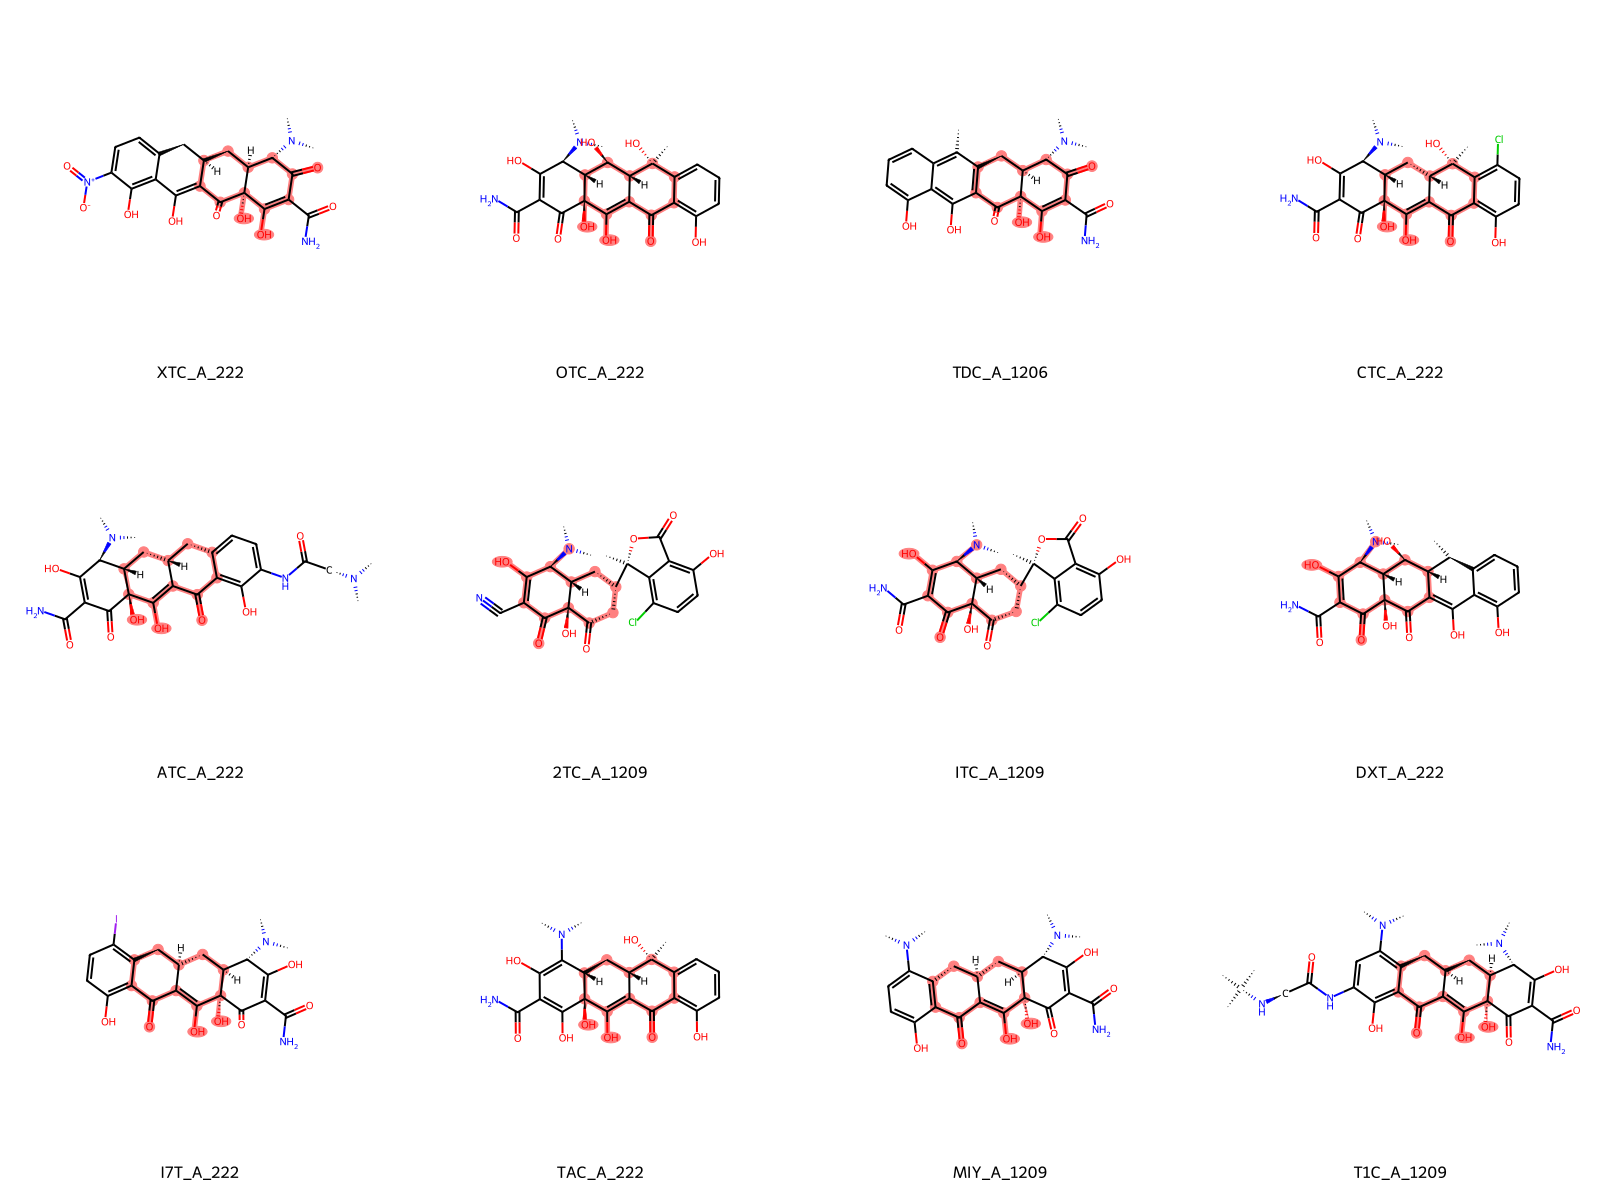

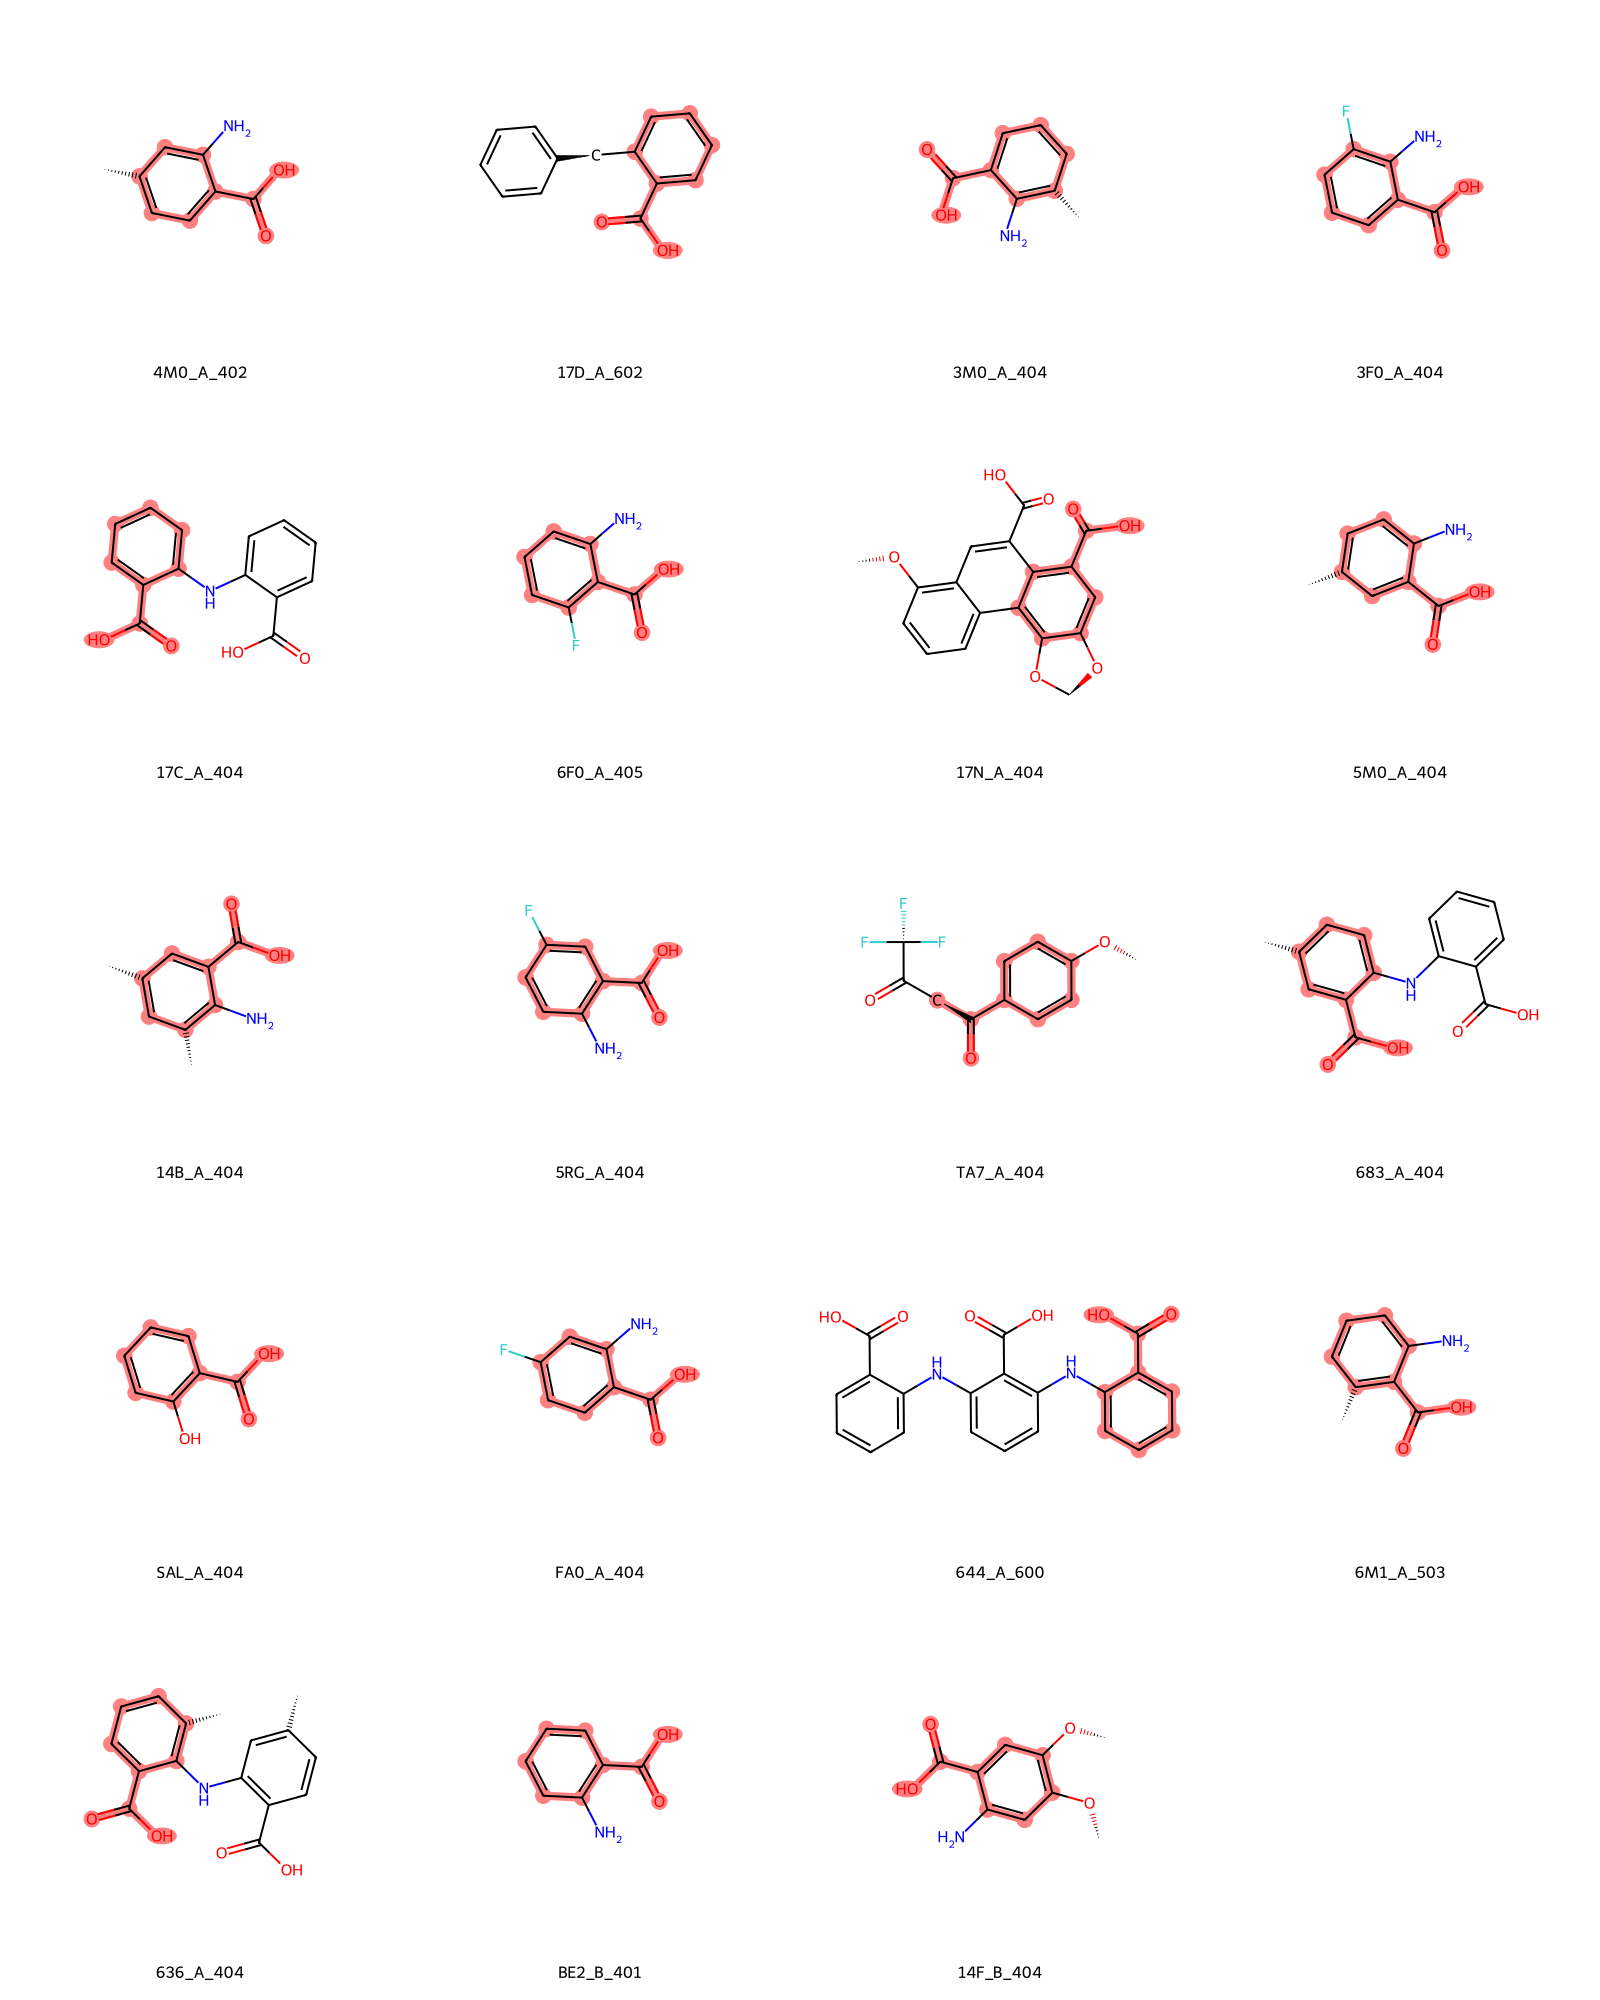

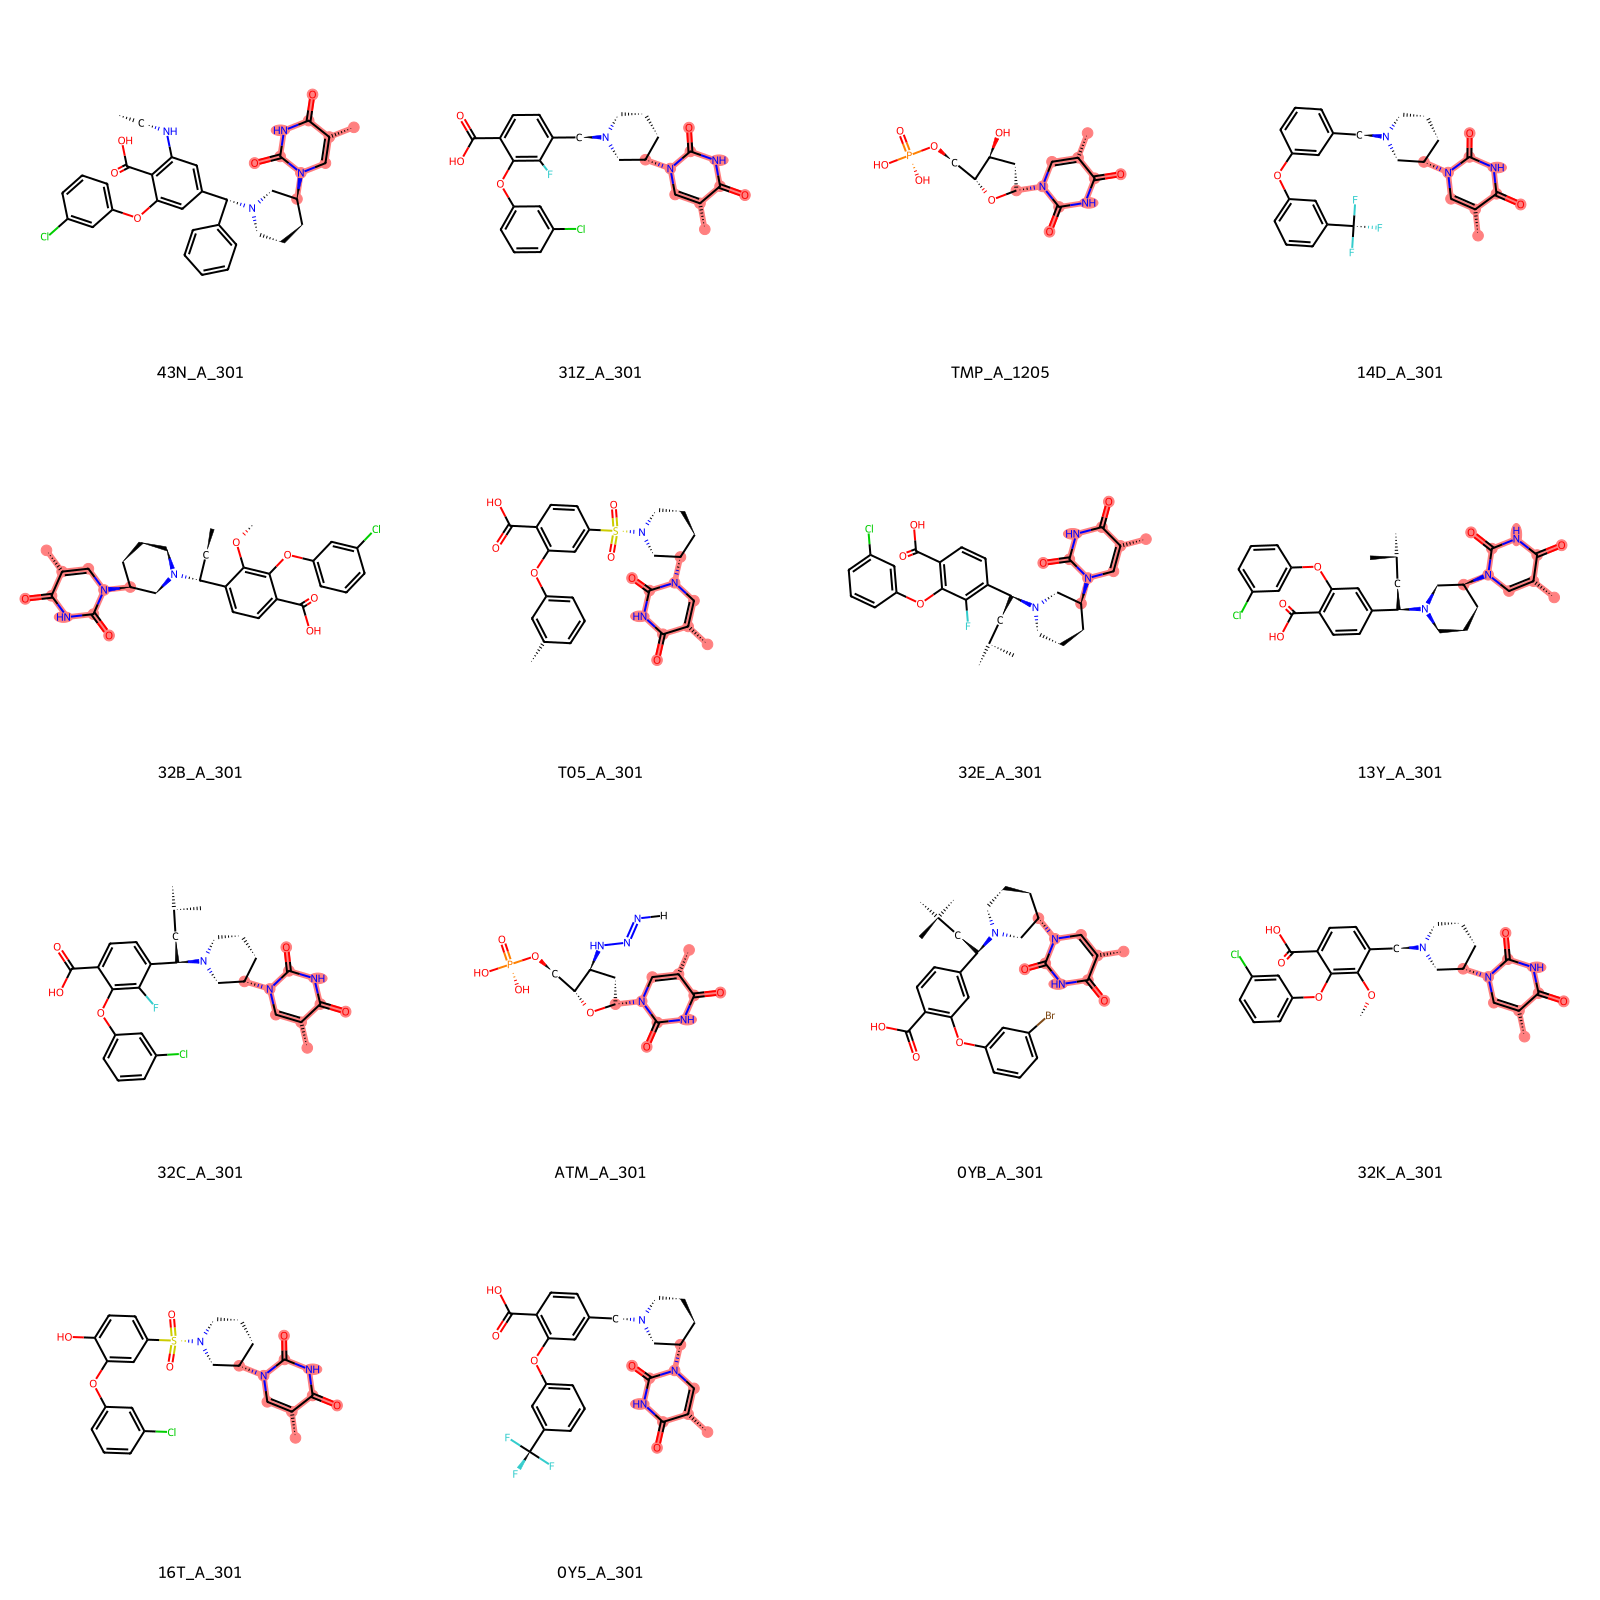

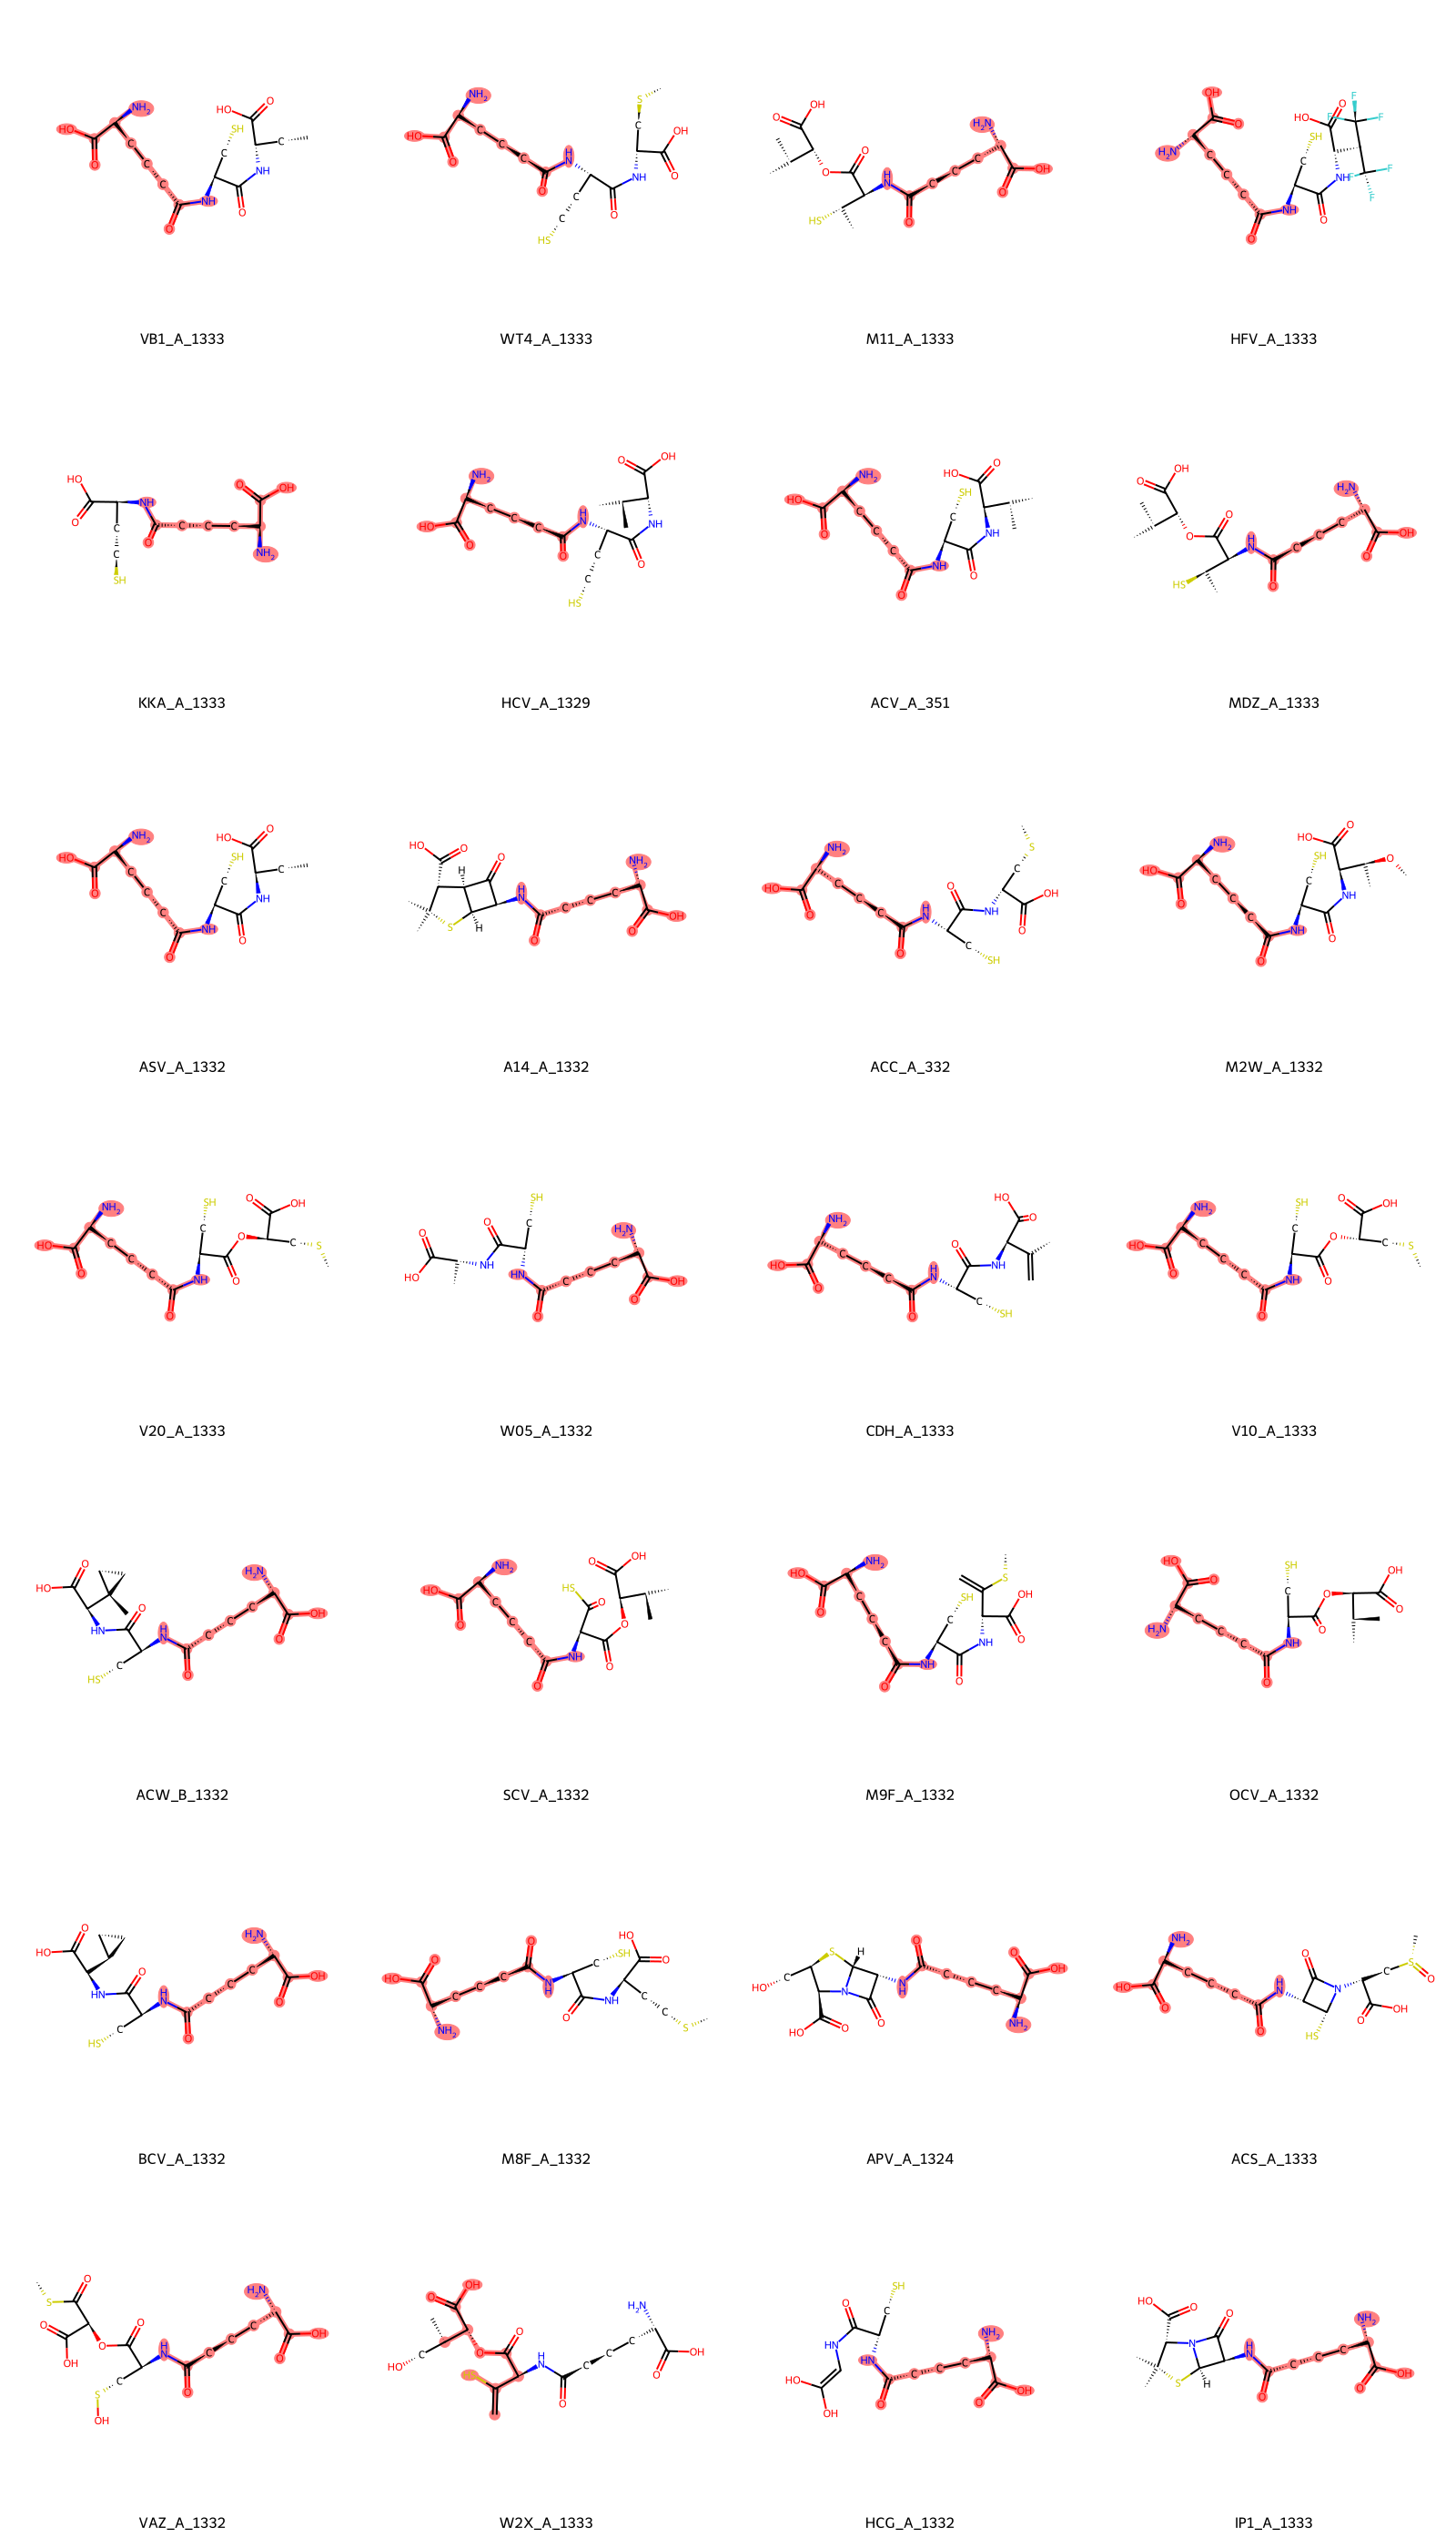

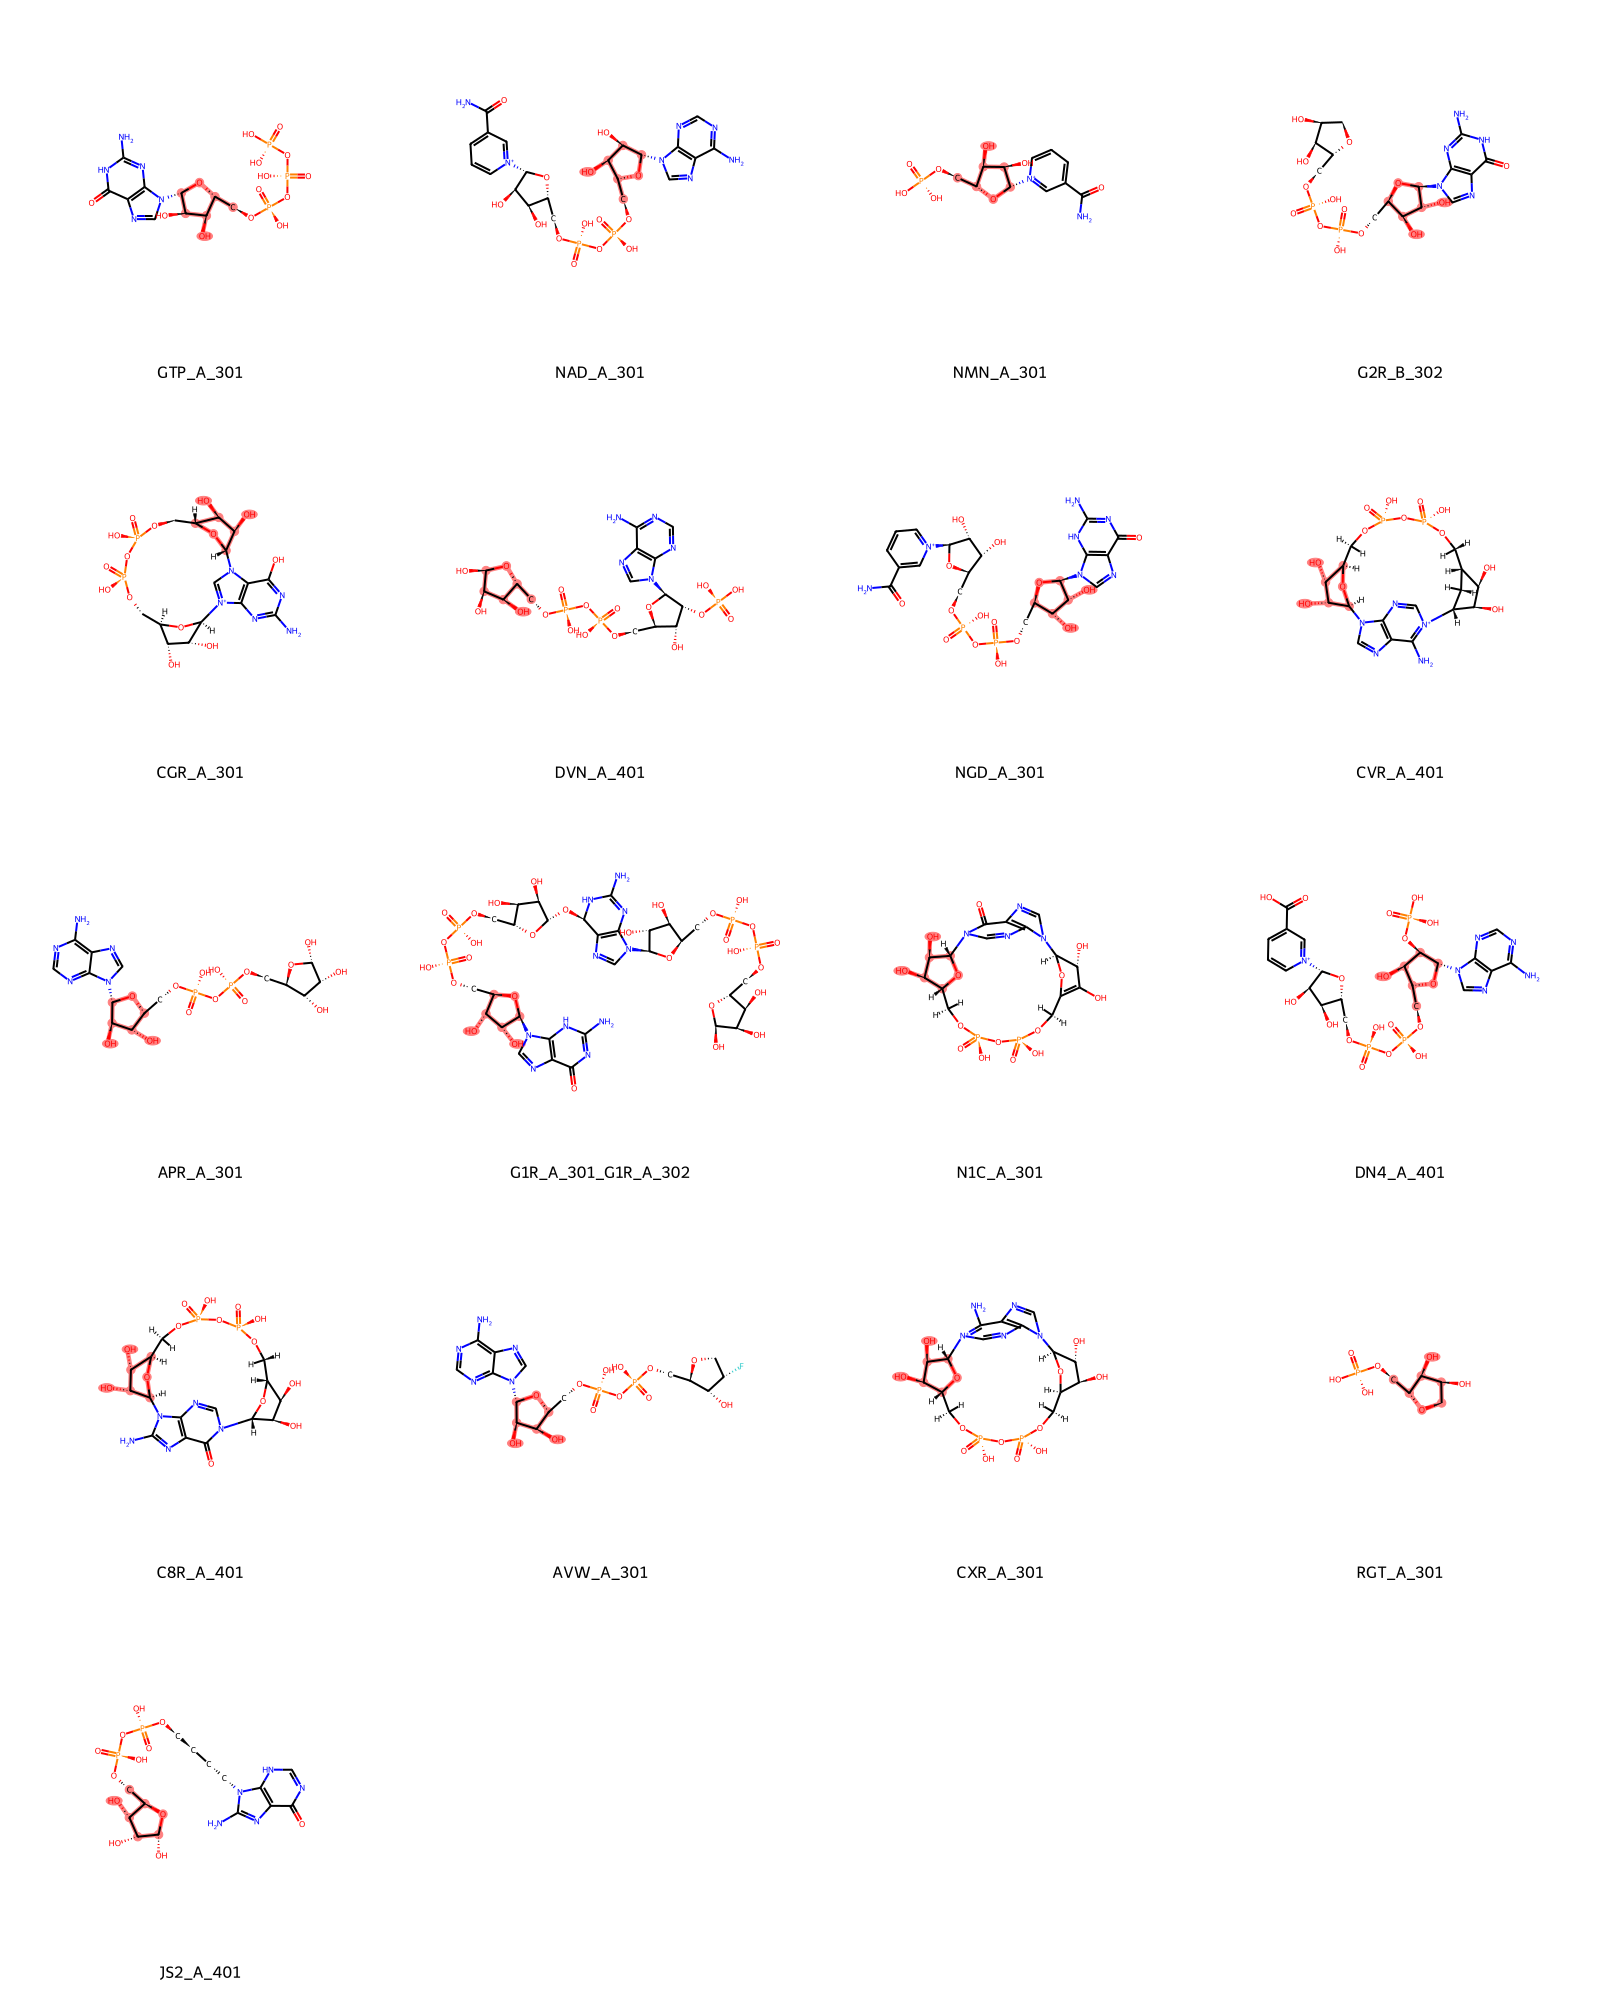

In [2]:
nbse_dir = '../nbse'

for n in ['3pci', '1d0s', '3ke8', '2w0v', '2vke', '3qqs', '4gfd', '1odn', '2hct']:
    dir = os.path.join(nbse_dir, n, 'ligands')
    mols = get_nbse_mols(dir)

    for m in mols:
        AllChem.Compute2DCoords(m)
        AllChem.SanitizeMol(m)

    mols = list(map(AllChem.RemoveHs, mols))

    mcs: rdFMCS.MCSResult = rdFMCS.FindMCS(mols,
                                           ringMatchesRingOnly=True,
                                           matchChiralTag=False,
                                           completeRingsOnly=True,
                                           atomCompare=rdFMCS.AtomCompare.CompareAnyHeavyAtom,
                                           bondCompare=rdFMCS.BondCompare.CompareOrder)
    #mols = random.sample(mols, 9)

    hla = []
    hlb = []
    m: AllChem.Mol
    for m in mols:
        am = list(m.GetSubstructMatch(mcs.queryMol))
        hla.append(am)
        bm = []
        for bond in mcs.queryMol.GetBonds():
            aid1 = am[bond.GetBeginAtomIdx()]
            aid2 = am[bond.GetEndAtomIdx()]
            bm.append(m.GetBondBetweenAtoms(aid1,aid2).GetIdx())
        
        hlb.append(bm)
        
    display(Draw.MolsToGridImage(mols, molsPerRow=4,subImgSize=(400,400),legends=[x.GetProp("_Name") for x in mols], highlightBondLists=hlb, highlightAtomLists=hla))

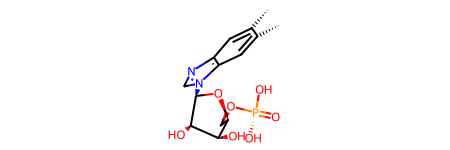